## Berlin Temperature Pattern Analysis

Source: The National Centers for Environmental Information (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Daily).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

# Loading and Exploring the Data

df = pd.read_csv('Berlin_Weather.csv')
df.head()

,STATION,DATE,PRCP,SNWD,TMAX,TMIN
0,GME00111445,2010-01-01,0.2,NaN,-0.7,-2.3
1,GME00111445,2010-01-02,1.4,NaN,-0.6,-3.6
2,GME00111445,2010-01-03,0.0,NaN,-2.9,-6.2
3,GME00111445,2010-01-04,0.0,NaN,-4.9,-7.3
4,GME00111445,2010-01-05,0.0,NaN,-4.6,-10.7


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43877 entries, 0 to 43876
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  43877 non-null  object 
 1   DATE     43877 non-null  object 
 2   PRCP     39527 non-null  float64
 3   SNWD     29192 non-null  float64
 4   TMAX     39523 non-null  float64
 5   TMIN     39523 non-null  float64
dtypes: float64(4), object(2)
memory usage: 2.0+ MB


In [3]:
df.describe()

,PRCP,SNWD,TMAX,TMIN
count,39527.000000,29192.000000,39523.000000,39523.000000
mean,1.511640,8.213552,14.732406,5.898143
std,4.104154,38.317058,9.193880,6.814342
min,0.000000,0.000000,-11.900000,-23.800000
25%,0.000000,0.000000,7.600000,1.000000
50%,0.000000,0.000000,14.700000,5.900000
75%,1.200000,0.000000,22.200000,11.200000
max,196.900000,460.000000,38.900000,23.900000


First we'll visualize the stations geographical location using the `folium` package:

In [11]:
import folium

# Latitude and Longitude coordinates for each station can be found in the ghcnd-stations.text dataset

stations = pd.read_fwf("ghcnd-stations.txt", header=None, usecols=[0, 1, 2], names=["STATION", "LAT", "LONG"])
stations.set_index("STATION", inplace=True)

berlin_stations = stations.loc[df["STATION"].unique()]

# Get longitude and lattitude to plot

lons = berlin_stations['LONG'].tolist()
lats = berlin_stations['LAT'].tolist()

# Plot on a beautiful folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# Render map in Jupyter
display(my_map)

Now let's return our attention to the `df` dataset, and do a bit of data manipulation:

In [5]:
# Preparing the Data

df = df[~(df["DATE"].str.contains('02-29'))] # Drops leap days

df["DATE"] = pd.to_datetime(df["DATE"]) # Pandas Date Functionality
df["MONTH"] = df["DATE"].dt.month
df["DAY"] = df["DATE"].dt.day

df.set_index("DATE", inplace=True)
df.head()

,STATION,PRCP,SNWD,TMAX,TMIN,MONTH,DAY
DATE,,,,,,,
2010-01-01,GME00111445,0.2,NaN,-0.7,-2.3,1,1
2010-01-02,GME00111445,1.4,NaN,-0.6,-3.6,1,2
2010-01-03,GME00111445,0.0,NaN,-2.9,-6.2,1,3
2010-01-04,GME00111445,0.0,NaN,-4.9,-7.3,1,4
2010-01-05,GME00111445,0.0,NaN,-4.6,-10.7,1,5


In [6]:
# Separating by Years

df_1019 = df.loc[:"2019"]
df_20 = df.loc["2020"]

In [7]:
# Temperature Summarizing

df_1019 = df_1019.groupby(["MONTH", "DAY"]).agg({"TMAX": np.max, "TMIN": np.min}).reset_index()
df_20 = df_20.groupby(["MONTH", "DAY"]).agg({"TMAX": np.max, "TMIN": np.min}).reset_index()

# Days in 2020 where a temperature record was broken

d_max = np.where(df_20['TMAX'] > df_1019['TMAX'])
d_min = np.where(df_20['TMIN'] < df_1019["TMIN"])

Let's visualize the temperature maximum and minimum values from 2010 to 2019 using heatmaps:

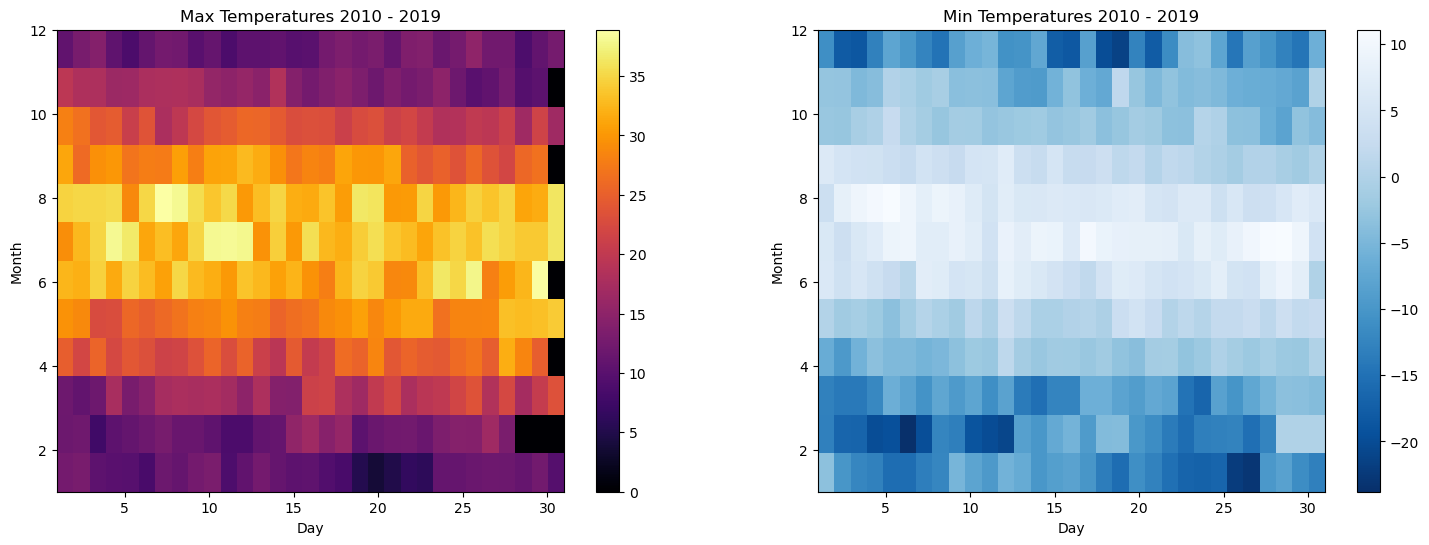

In [8]:
# Plotting

plt.figure(figsize=(18,6))

## Max Temperatures Heat Map

plt.subplot(121)
plt.hist2d(df_1019["DAY"],
          df_1019["MONTH"],
          bins=[31,12],
          weights = df_1019["TMAX"],
          cmap ="inferno")
plt.colorbar()
plt.title("Max Temperatures 2010 - 2019")
plt.xlabel("Day")
plt.ylabel("Month")

## Min Temperatures Heat Map

plt.subplot(122)
orig_map=plt.cm.get_cmap('Blues')
reversed_map = orig_map.reversed()
plt.hist2d(df_1019["DAY"],
          df_1019["MONTH"],
          bins=[31,12],
          weights = df_1019["TMIN"],
          cmap =reversed_map)
plt.colorbar()
plt.title("Min Temperatures 2010 - 2019")
plt.xlabel("Day")
plt.ylabel("Month");

Now we'll take a look at days in 2020 where extreme temperature was recorded. First we'll plot lines for the `TMAX`  and `TMIN` aggregates for the decade, and then overlay a scatter plot with the record breaking temperatures in 2020.

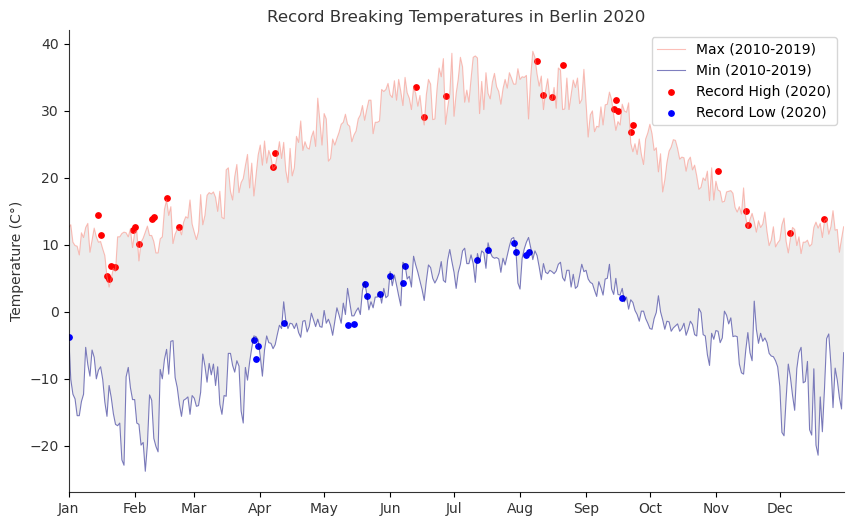

In [9]:
# Plotting

plt.figure(figsize=(10,6))

## Line Plot

plt.plot(df_1019["TMAX"], color = "salmon", alpha = 0.5, linewidth = 0.8, label = "Max (2010-2019)")
plt.plot(df_1019["TMIN"], color = "navy", alpha = 0.5, linewidth = 0.8, label = "Min (2010-2019)")
plt.gca().fill_between(df_1019.index,
                       df_1019["TMIN"],
                       df_1019["TMAX"],
                       facecolor = "grey",
                       alpha = 0.15)

## Scatter Plot

plt.scatter(d_max, df_20.iloc[d_max]["TMAX"], s=15, c="red", label = "Record High (2020)")
plt.scatter(d_min, df_20.iloc[d_min]["TMIN"], s=15, c="blue", label = "Record Low (2020)")

## x-ticks date formatting

plt.xlim(0,364)
months = MonthLocator()
monthsFmt = DateFormatter("%b")
ax = plt.gca()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)

## Dejunking

plt.ylabel("Temperature (C°)", alpha = 0.8)
ax.spines[['right','top']].set_visible(False)
ax.spines[['bottom','left']].set_alpha(0.8)
plt.xticks(alpha = 0.8)
plt.yticks(alpha = 0.8)

## Legend

plt.legend(loc = 1)
plt.title("Record Breaking Temperatures in Berlin 2020", alpha = 0.8);